In [76]:
import fiona
from shapely.geometry import shape, MultiPolygon, mapping, Polygon
from fiona.crs import from_epsg
from shapely.ops import unary_union
import geopandas as gpd
from matplotlib import pyplot as plt

In [24]:
def to_valid_multipolygon(geom):
    if not geom.is_valid:
        geom = geom.buffer(0.0)
    if not isinstance(geom, MultiPolygon):
        geom = MultiPolygon([geom])
    assert geom.is_valid
    return geom    

In [25]:
usa = {}

for i, layername in enumerate(fiona.listlayers('zip://data/natural-earth/ne_10m_admin_1_states_provinces.zip')):
    with fiona.open('zip://data/natural-earth/ne_10m_admin_1_states_provinces.zip', layer=i) as src:
        usa = {
            feature['properties']['name']: to_valid_multipolygon(shape(feature['geometry']))
            for feature in src
            if feature['properties']['admin'] == 'United States of America'
        }

In [28]:
cutouts = {}

with fiona.open('data/cutouts_spp.gpkg', layer=0) as src:
    cutouts = {
        feature['properties']['name']: to_valid_multipolygon(shape(feature['geometry']))
        for feature in src
    }

In [29]:
cutouts

{'mro_nm': <shapely.geometry.multipolygon.MultiPolygon at 0x11eda79b0>,
 'mro_texas1': <shapely.geometry.multipolygon.MultiPolygon at 0x11eda7828>,
 'wecc_texas': <shapely.geometry.multipolygon.MultiPolygon at 0x11eda7a58>,
 'mro_texas_east': <shapely.geometry.multipolygon.MultiPolygon at 0x11eda7a90>,
 'tre_ok': <shapely.geometry.multipolygon.MultiPolygon at 0x11eda7ac8>}

In [50]:
with fiona.open('data/cutouts/mro.gpkg', layer=0) as src:
    mro_cutout = to_valid_multipolygon(shape(next(iter(src))['geometry']))
    
with fiona.open('data/cutouts/mro_ill.gpkg', layer=0) as src:
    mro_ill_cutout = to_valid_multipolygon(shape(next(iter(src))['geometry']))    

In [42]:
with fiona.open('data/cutouts/serc.gpkg', layer=0) as src:
    serc_cutout = to_valid_multipolygon(shape(next(iter(src))['geometry']))

In [43]:
def plot(geom):
    gpd.GeoSeries(geom).plot()
    plt.show()
    return plt

# WECC

In [85]:
wecc = unary_union(
    [cutouts['wecc_texas'].intersection(usa['Texas']), usa['New Mexico'].difference(cutouts['mro_nm'])] + 
    [usa[key].difference(mro_cutout) for key in ('Montana', 'South Dakota', 'Nebraska')] + 
    [usa[key] for key in 
        ('Washington', 'Oregon', 'California', 'Idaho', 'Wyoming', 'Utah', 'Arizona', 'Nevada', 'Colorado')
     ]
)

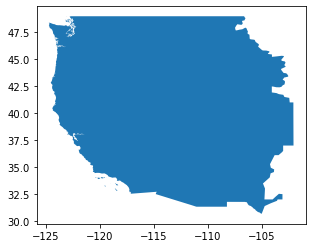

In [86]:
gpd.GeoSeries(wecc).plot()
plt.show()

# MRO

In [82]:
mro = unary_union(
    [    
        cutouts['mro_nm'].intersection(usa['New Mexico']), 
        cutouts['mro_texas1'].intersection(usa['Texas']),
        cutouts['mro_texas_east'].intersection(usa['Texas']).difference(serc_cutout),
        usa['Oklahoma'].difference(cutouts['tre_ok']),
        mro_ill_cutout.intersection(usa['Illinois'])
    ] +    
    [usa[key].difference(serc_cutout) for key in ('Missouri', 'Arkansas', 'Louisiana')] + 
    [usa[key].intersection(mro_cutout) for key in ('Montana', 'South Dakota', 'Nebraska', 'Wisconsin')] + 
    [usa[key] for key in 
        ('North Dakota', 'Kansas', 'Iowa', 'Minnesota')
     ]
)

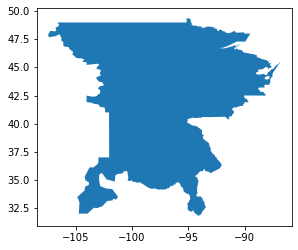

<module 'matplotlib.pyplot' from '/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [83]:
plot(mro)

# SERC

In [56]:
serc = unary_union(
    [
        usa[key].intersection(serc_cutout)
        for key in 
        ('Missouri', 'Arkansas', 'Louisiana', 'Texas', 'Illinois', 'Virginia', 'Kentucky', 'Florida')] + 
    [usa[key] for key in 
        ('Tennessee', 'Alabama', 'Mississippi', 'Georgia', 'South Carolina', 'North Carolina', )
     ]
)

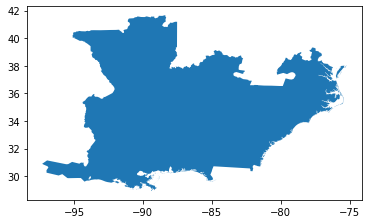

<module 'matplotlib.pyplot' from '/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [57]:
plot(serc)

# TRE

In [59]:
tre = unary_union(
    [
        usa['Texas'].difference(serc_cutout).difference(cutouts['wecc_texas']).difference(
            cutouts['mro_texas1']).difference(cutouts['mro_texas_east']),
        usa['Oklahoma'].intersection(cutouts['tre_ok']),
    ]
)

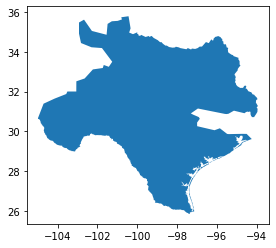

<module 'matplotlib.pyplot' from '/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [60]:
plot(tre)

# NPCC

In [61]:
npcc = unary_union(
    [usa[key] for key in 
        ('New York', 'Connecticut', 'Rhode Island', 'Massachusetts', 'Vermont', 'New Hampshire', 'Maine')
     ]
)

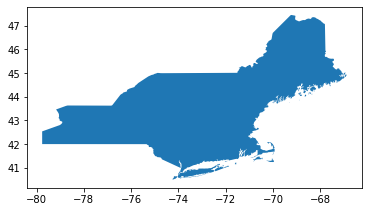

<module 'matplotlib.pyplot' from '/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [62]:
plot(npcc)

# FRCC

In [63]:
frcc = usa['Florida'].difference(serc_cutout)

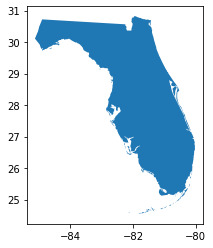

<module 'matplotlib.pyplot' from '/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [64]:
plot(frcc)

# RFC

In [67]:
rfc = unary_union(
    [
        usa['Illinois'].difference(mro_ill_cutout).difference(serc_cutout),
        usa['Wisconsin'].difference(mro_cutout),
    ] + 
    [
        usa[key].difference(serc_cutout)
        for key in 
        ('Virginia', 'Kentucky')] + 
    [usa[key] for key in 
        ('Indiana', 'Ohio', 'West Virginia', 'District of Columbia', 'Maryland', 'Delaware', 'Pennsylvania', 'New Jersey', 'Michigan')
     ]
)

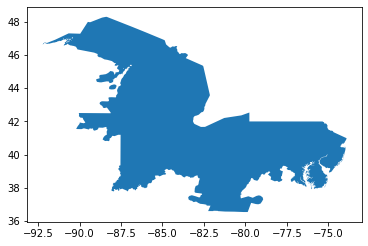

<module 'matplotlib.pyplot' from '/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [68]:
plot(rfc)

# Fix interior holes with zero area

In [ ]:
from shapely.geometry import Polygon
africa2 = Polygon(africa.exterior)

for ring in poly.interiors:
    pol = Polygon(ring)
    if(pol.area < maxAreaTh):
        poly = poly.union(pol.buffer(0.3))
return poly

In [78]:
def fix_multipolygon(geom):
    mp = to_valid_multipolygon(geom)
    return MultiPolygon([remove_small_holes(obj) for obj in geom])

In [80]:
def remove_small_holes(polygon, max_area = 1e-4):
    for ring in polygon.interiors:
        ring_geom = Polygon(ring)
        if(ring_geom.area < max_area):
            polygon = polygon.union(ring_geom.buffer(1e-5))
    return polygon

# Write geometries to new Geopackage

In [87]:
schema =  {
    'geometry': 'MultiPolygon',
    'properties': {'name': 'str'},
}

data = [
    (frcc, 'frcc'),
    (mro, 'mro'),
    (serc, 'serc'),
    (npcc, 'npcc'),
    (wecc, 'wecc'),
    (rfc, 'rfc'),
    (tre, 'tre')
]

with fiona.open(
        'data/output/nerc_regions.gpkg', 
        'w',
        crs=from_epsg(4326),
        driver='GPKG', 
        schema=schema
    ) as output:
    for x, y in data:
        output.write({'geometry': mapping(fix_multipolygon(to_valid_multipolygon(x))), 'properties': {'name': y}})